In [100]:
# buil-in
import datetime

# 3rd party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# custom
from gpw_data import GPWData

plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib notebook

In [4]:
# strategy 1 tests

data = GPWData()
etfw20l = data.load(symbols='ETFW20L')

# params
time_window = 8 #3  # 8/9 daje najlepsze jak na razie
"""
przy time window 3-7 jest strata
przy 8-9 lepiej niz b&h
przy >=10 gorzej niz b&h

ale to tylko dla etf-WIG20. dla s&p i dex jest totalnie gorzej...
"""
# long_threshold = 35
# short_threshold = 25
long_threshold = 35
short_threshold = 30
"""
"""

# calculate signals
# etf10 = pd.DataFrame(etfw20l.head(10)) # creates new DataFrame object (not a copy of df)
for price in ('high', 'low', 'close'):
    etfw20l.loc[:, 'ema_{}_{}'.format(time_window, price)] = etfw20l[price].ewm(span=time_window, adjust=False).mean()
# calculate ADR = EMA_H - EMA_L
etfw20l.loc[:, 'adr'] = etfw20l['ema_{}_high'.format(time_window)] - etfw20l['ema_{}_low'.format(time_window)]
# calculate perc = ((EMA_H - EMA_C)*100)/ADR
etfw20l.loc[:, 'perc_range'] = ((etfw20l['ema_{}_high'.format(time_window)]-etfw20l['ema_{}_close'.format(time_window)])*100)/etfw20l['adr']

for signal_type in ('long', 'short'):
    if signal_type == 'long':
        etfw20l.loc[:, 'potential_signal'] = np.where(etfw20l['perc_range'] > long_threshold, 1, 0)
    elif signal_type == 'short':
        etfw20l.loc[:, 'potential_signal'] = np.where(etfw20l['perc_range'] < short_threshold, 1, 0)
    etfw20l.loc[:, 'previous_potential_signal'] = etfw20l['potential_signal'].shift(1)
    etfw20l['previous_potential_signal'].fillna(value=0, inplace=True)
    etfw20l.loc[:, 'entry_{}'.format(signal_type)] = np.where(
        (etfw20l['potential_signal']==1) & (etfw20l['previous_potential_signal']==0), 1, 0
    )
    etfw20l.loc[:, 'exit_{}'.format(signal_type)] = np.where(
        (etfw20l['potential_signal']==0) & (etfw20l['previous_potential_signal']==1), 1, 0
    )
    etfw20l.drop(['potential_signal', 'previous_potential_signal'], axis=1, inplace=True)

print(etfw20l.head(15))

              open    high     low   close  volume  ema_8_high   ema_8_low  \
date                                                                         
2010-09-28  262.40  263.30  261.40  261.40    1334  263.300000  261.400000   
2010-09-29  262.90  264.50  262.40  262.50    1194  263.566667  261.622222   
2010-09-30  262.17  265.15  261.47  265.15    3802  263.918519  261.588395   
2010-10-01  264.16  265.50  264.00  264.80    5170  264.269959  262.124307   
2010-10-04  268.00  268.00  263.00  266.43   14490  265.098857  262.318906   
2010-10-05  266.58  275.00  265.82  275.00   15134  267.299111  263.096927   
2010-10-06  272.31  273.20  269.80  270.50    2294  268.610420  264.586498   
2010-10-07  270.70  271.30  267.00  267.00    4315  269.208104  265.122832   
2010-10-08  267.90  268.60  265.40  265.40     464  269.072970  265.184425   
2010-10-11  265.87  267.40  265.83  266.70     949  268.701199  265.327886   
2010-10-12  264.90  267.20  264.00  265.98    1151  268.367599  

In [5]:
# gather entry/exist signals to visualize data
idxs_entry_long = etfw20l.index[etfw20l['entry_long'] == 1].tolist()
idxs_exit_long = etfw20l.index[etfw20l['exit_long'] == 1].tolist()
if len(idxs_entry_long) > len(idxs_exit_long):
    idxs_entry_long = idxs_entry_long[:-1]
elif len(idxs_exit_long) > len(idxs_entry_long):
    idxs_exit_long = idxs_exit_long[:-1]
elif len(idxs_entry_long) != len(idxs_exit_long):
    # logically they can differ only by 1, so if its not the case sth is wrong
    raise ValueError
long_periods = list(zip(idxs_entry_long, idxs_exit_long))

# same for short periods
idxs_entry_short = etfw20l.index[etfw20l['entry_short'] == 1].tolist()
idxs_exit_short = etfw20l.index[etfw20l['exit_short'] == 1].tolist()
if len(idxs_entry_short) > len(idxs_exit_short):
    idxs_entry_short = idxs_entry_short[:-1]
elif len(idxs_exit_short) > len(idxs_entry_short):
    idxs_exit_short = idxs_exit_short[:-1]
elif len(idxs_entry_short) != len(idxs_exit_short):
    # logically they can differ only by 1, so if its not the case sth is wrong
    raise ValueError
short_periods = list(zip(idxs_entry_short, idxs_exit_short))

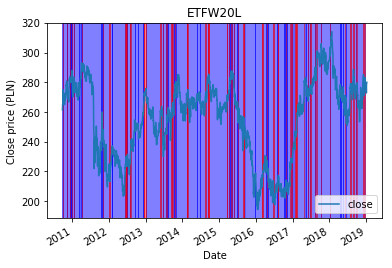

In [6]:
ax = etfw20l.plot(y='close')
plt.title('ETFW20L')
plt.xlabel('Date')
plt.ylabel('Close price (PLN)')

# add vertical spacing to depict holding periods
for lp in long_periods:
    ax.axvspan(lp[0], lp[1], alpha=0.5, color='blue')
for sp in short_periods:
    ax.axvspan(sp[0], sp[1], alpha=0.5, color='red')


In [7]:
# how many winning and loosing trades there is without transaction costs?
winning_trades = 0
loosing_trades = 0
for lp in long_periods:
    if etfw20l.loc[lp[1], 'close'] - etfw20l.loc[lp[0], 'close'] > 0:
        winning_trades += 1
    else:
        loosing_trades += 1
for sp in short_periods:
    if etfw20l.loc[sp[0], 'close'] - etfw20l.loc[sp[1], 'close'] > 0:
        winning_trades += 1
    else:
        loosing_trades += 1
        
print('Winning: ', winning_trades)
print('Loosing: ', loosing_trades)
# > 60% win-rate without transaction costs

Winning:  126
Loosing:  44


In [8]:
#### strategy backtest

# strategy setup
fee_perc=0.0038
min_fee_perc=4

# trades = {}
# returns = {}

def calculate_fee(shares_count=None, price=None):
    transaction_value = shares_count * price
    fee = transaction_value * fee_perc
    if fee < min_fee_perc:
        fee = min_fee_perc
    return round(fee, 2)

In [9]:
# dates = etfw20l.index.values.tolist()
# print(dates)

# zacznij najprosciej jak potrafisz - petla
# zakladam ze kupuje po cenie... ? https://www.experto24.pl/finanse-osobiste/gielda/kiedy-mozna-zawierac-transakcje-na-gieldzie.html
# jestem w stanie kupic po cenie zamkniecia
# moge tez to zrobic po TKO, tj. teoretyczny kurs otwarcia
# sprawdzmy oba (do obu jestem w stanie w stanie sie przystosowac)
counter = 0
counter_limit = 12 # 12tego i 13 sa po 2 trx tego samego dnia
initial_investment = 10000

etfw20l.loc[:, 'shares_count'] = 0
etfw20l.loc[:, 'returns'] = 0
etfw20l.loc[:, 'account_value'] = 0
etfw20l.loc[:, 'buy_and_hold'] = 0

available_money = 0
available_money += initial_investment #  10k PLN
shares_count = 0
account_value = 0

for idx, row in etfw20l.iterrows():
#     if counter >= counter_limit:
#         break
    
    if counter == 0:
        _shares_count = available_money // (row['close'] + (row['close']*fee_perc))
        _fee = calculate_fee(shares_count=_shares_count, price=row['close'])
        _account_value = _shares_count*row['close']
        _initial_investment = initial_investment - _fee
        _returns = ((_account_value-_initial_investment)/_initial_investment)*100
        etfw20l.loc[idx, 'buy_and_hold'] = _returns

    if row['exit_long'] == 1:
        fee = calculate_fee(shares_count=shares_count, price=row['close'])
        available_money += (shares_count*row['close'])-fee
        
        shares_count = 0
        account_value = 0
        
        etfw20l.loc[idx, 'shares_count'] = shares_count
        etfw20l.loc[idx, 'account_value'] = account_value
        
    if row['exit_short'] == 1:
        fee = calculate_fee(shares_count=-shares_count, price=row['close'])
        available_money -= (-shares_count*row['close'])+fee
        
        shares_count = 0
        account_value = 0
        
        etfw20l.loc[idx, 'shares_count'] = shares_count
        etfw20l.loc[idx, 'account_value'] = account_value
        
    if row['entry_long'] == 1:
        shares_count = available_money // (row['close'] + (row['close']*fee_perc))
        fee = calculate_fee(shares_count=shares_count, price=row['close'])
        account_value = shares_count*row['close']
        available_money -= account_value+fee
        
        etfw20l.loc[idx, 'shares_count'] = shares_count
        etfw20l.loc[idx, 'account_value'] = account_value
        
    if row['entry_short'] == 1:
        shares_count = -1 * (available_money // (row['close'] + (row['close']*fee_perc)))
        fee = calculate_fee(shares_count=shares_count, price=row['close'])
        
        account_value = shares_count*row['close']
        available_money += (-1*shares_count*row['close'])-fee
        
        etfw20l.loc[idx, 'shares_count'] = shares_count
        etfw20l.loc[idx, 'account_value'] = account_value

    if (row['entry_long'] == 0)&(row['exit_long'] == 0)&(row['entry_short'] == 0)&(row['exit_short'] == 0):
        # wartosc poprzednia....
        etfw20l.loc[idx, 'shares_count'] = shares_count
        etfw20l.loc[idx, 'account_value'] = shares_count*row['close']


    # etfw20l['returns'] = (((etfw20l['account_value']+available_money)-initial_investment)/initial_investment)*100
    returns = (((account_value+available_money)-initial_investment)/initial_investment)*100
    etfw20l.loc[idx, 'returns'] = returns
    etfw20l.loc[idx, 'buy_and_hold'] = ((_shares_count*row['close']-_initial_investment)/_initial_investment)*100
    
    # print(etfw20l.loc[idx,['close', 'shares_count', 'account_value', 'returns']])
    # print('avaiable_money: ', round(available_money,2) )
    # print('\n')
    
    counter += 1

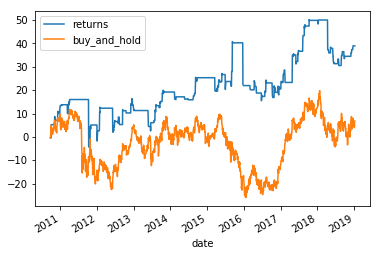

In [10]:
ax2 = etfw20l.plot(y=['returns', 'buy_and_hold'])

In [11]:
"""
- trzeba sprawdzic dokladniej jak mocno wplywaja moje parametry na wyniki strategi
- najlepiej tez podzielic na seen/unseen zeby unikac snoopinf bias
- mozna by tez podzielic na rozne okresy zeby sprawdziac w wielu okresach
- no i oczywiscie dla kazdej opcji powinny byc liczone sharp, ret std.dev, max dd, alfa
- seen/unseen to tak na prawde training(optimization) i test(validation). moze byc ratio 50:50
- pilnuj sie zeby test/validation nie posluzyl Ci do optymalizacji. tj. wybierasz najlepiej zoptymalizowane.
  nie patrzysz na wszystkie rezultaty test sets. bo innaczej bedziesz chcial wybrac najlepszy rezultat z test
  co tak na prawde znaczy ze optymalizujesz na test set (wiec bedziesz mial data snooping bias)
- czy jestem w stanie jeszcze jakos lepiej przetestowac.... tj. jezeli podziele calos na 2, to mam optymalizaje i test
  tylko i wylacznie na 1 i 1 zestawie... to moze miec dosc duzy wplyw - tj. co by sie stalo jak bym zaczal 
  optymalizowac w okresie pol roku pozienijszym? czy dalej te same parametry sie spelniaja?
  
- dobra na razie nie ma co pierdolic bo sie zatne i nigdy nie rusze do przodu. musze isc szybko i malymi krokami. 
  systematycznie ilepszac itp a nie probowac zrobic ideal od razu
""";

In [63]:
def optimize(symbol=None, time_window=3, long_threshold=35, short_threshold=30):
    """
    strategy params: time_window, long_threshold, short_threshold
    """
    data = GPWData()
    etf_full = data.load(symbols=symbol)
    
    # split data into optimize/validate
    length = len(etf_full.index)
    etf_t = etf_full.iloc[:length//2, :].copy()
    etf_v = etf_full.iloc[length//2:, :].copy()
    
    # calculate signals
    for etf in (etf_t, etf_v):
        for price in ('high', 'low', 'close'):
            etf.loc[:, 'ema_{}_{}'.format(time_window, price)] = etf[price].ewm(span=time_window, adjust=False).mean()
        etf.loc[:, 'adr'] = etf['ema_{}_high'.format(time_window)] - etf['ema_{}_low'.format(time_window)]
        etf.loc[:, 'perc_range'] = \
            ((etf['ema_{}_high'.format(time_window)]-etf['ema_{}_close'.format(time_window)])*100)/etf['adr']
        
        for signal_type in ('long', 'short'):
            if signal_type == 'long':
                etf.loc[:, 'potential_signal'] = np.where(etf['perc_range'] > long_threshold, 1, 0)
            elif signal_type == 'short':
                etf.loc[:, 'potential_signal'] = np.where(etf['perc_range'] < short_threshold, 1, 0)
            etf.loc[:, 'previous_potential_signal'] = etf['potential_signal'].shift(1)
            etf['previous_potential_signal'].fillna(value=0, inplace=True)
            etf.loc[:, 'entry_{}'.format(signal_type)] = np.where(
                (etf['potential_signal']==1) & (etf['previous_potential_signal']==0), 1, 0
            )
            etf.loc[:, 'exit_{}'.format(signal_type)] = np.where(
                (etf['potential_signal']==0) & (etf['previous_potential_signal']==1), 1, 0
            )
            etf.drop(['potential_signal', 'previous_potential_signal'], axis=1, inplace=True)
            
    
    for etf in (etf_t, etf_v):
        # run backtest
        initial_investment = 10000
        available_money = 0
        available_money += initial_investment #  10k PLN
        shares_count = 0
        account_value = 0

        etf.loc[:, 'shares_count'] = 0
        etf.loc[:, 'daily_returns'] = 0
        etf.loc[:, 'rate_of_return'] = 0
        etf.loc[:, 'account_value'] = 0
        etf.loc[:, 'NAV'] = 0
        etf.loc[:, 'b_and_h_ror'] = 0  # buy&hold rate of return
        etf.loc[:, 'b_and_h_nav'] = 0
        
        # run tested strategy
        for idx, row in etf.iterrows():
            fee = calculate_fee(shares_count=abs(shares_count), price=row['close'])
            
            if row['exit_long'] == 1:
                available_money += (shares_count*row['close'])-fee
                shares_count = 0
                account_value = 0
                
            if row['exit_short'] == 1:
                available_money -= (-shares_count*row['close'])+fee
                shares_count = 0
                account_value = 0
                
            if row['entry_long'] == 1:
                shares_count = available_money // (row['close'] + (row['close']*fee_perc))
                account_value = shares_count*row['close']
                available_money -= account_value+fee

            if row['entry_short'] == 1:
                shares_count = -1 * (available_money // (row['close'] + (row['close']*fee_perc)))
                account_value = shares_count*row['close'] # that is negative
                available_money += (-1*account_value)-fee
                
            if (row['entry_long'] == 0)&(row['exit_long'] == 0)&(row['entry_short'] == 0)&(row['exit_short'] == 0):
                account_value = shares_count*row['close']
            
            etf.loc[idx, 'shares_count'] = shares_count
            etf.loc[idx, 'account_value'] = account_value
            
            nav = account_value+available_money
            etf.loc[idx, 'NAV'] = nav

            rate_of_return = ((nav-initial_investment)/initial_investment)*100
            etf.loc[idx, 'rate_of_return'] = rate_of_return
            
        # run buy&hold benchmark
        counter = 0
        for idx, row in etf.iterrows():
            if counter == 0:
                _shares_count = initial_investment // (row['close'] + (row['close']*fee_perc))
                _fee = calculate_fee(shares_count=_shares_count, price=row['close'])
                _account_value = _shares_count*row['close']
                _initial_investment = initial_investment - _fee
                _available_money = initial_investment - _fee - _account_value  # left from the first purchease
                _rate_of_return = ((_account_value-_initial_investment)/_initial_investment)*100
                etf.loc[idx, 'b_and_h_ror'] = _rate_of_return
            _account_value = _shares_count*row['close']
            _nav = _account_value+_available_money
            etf.loc[idx, 'b_and_h_ror'] = ((_nav-_initial_investment)/_initial_investment)*100
            etf.loc[idx, 'b_and_h_nav'] = _nav
            # print('buy and hold theoretical nav... ', _account_value)
            counter += 1
            
    # calculate rerurns
    # To find the return R(t1,t2) between dates t1 and t2 one takes  R(t1,t2)=NAV(t2)/NAV(t1)−1
    for etf in (etf_t, etf_v):
        etf.loc[:,'NAV_prev'] = etf['NAV'].shift(1)
        etf.loc[:,'daily_returns'] = etf['NAV']/etf.loc[:,'NAV_prev']-1
        
        etf.loc[:,'b_and_h_nav_prev'] = etf['b_and_h_nav'].shift(1)
        # etf.loc[:,'b_and_h_daily_returns'] = etf.loc[:,'b_and_h_nav_prev']/etf['b_and_h_nav']-1
        etf.loc[:,'b_and_h_daily_returns'] = etf['b_and_h_nav']/etf.loc[:,'b_and_h_nav_prev']-1

    return etf_t, etf_v
            
etf_t, etf_v = optimize(symbol='ETFW20L')

<IPython.core.display.Javascript object>


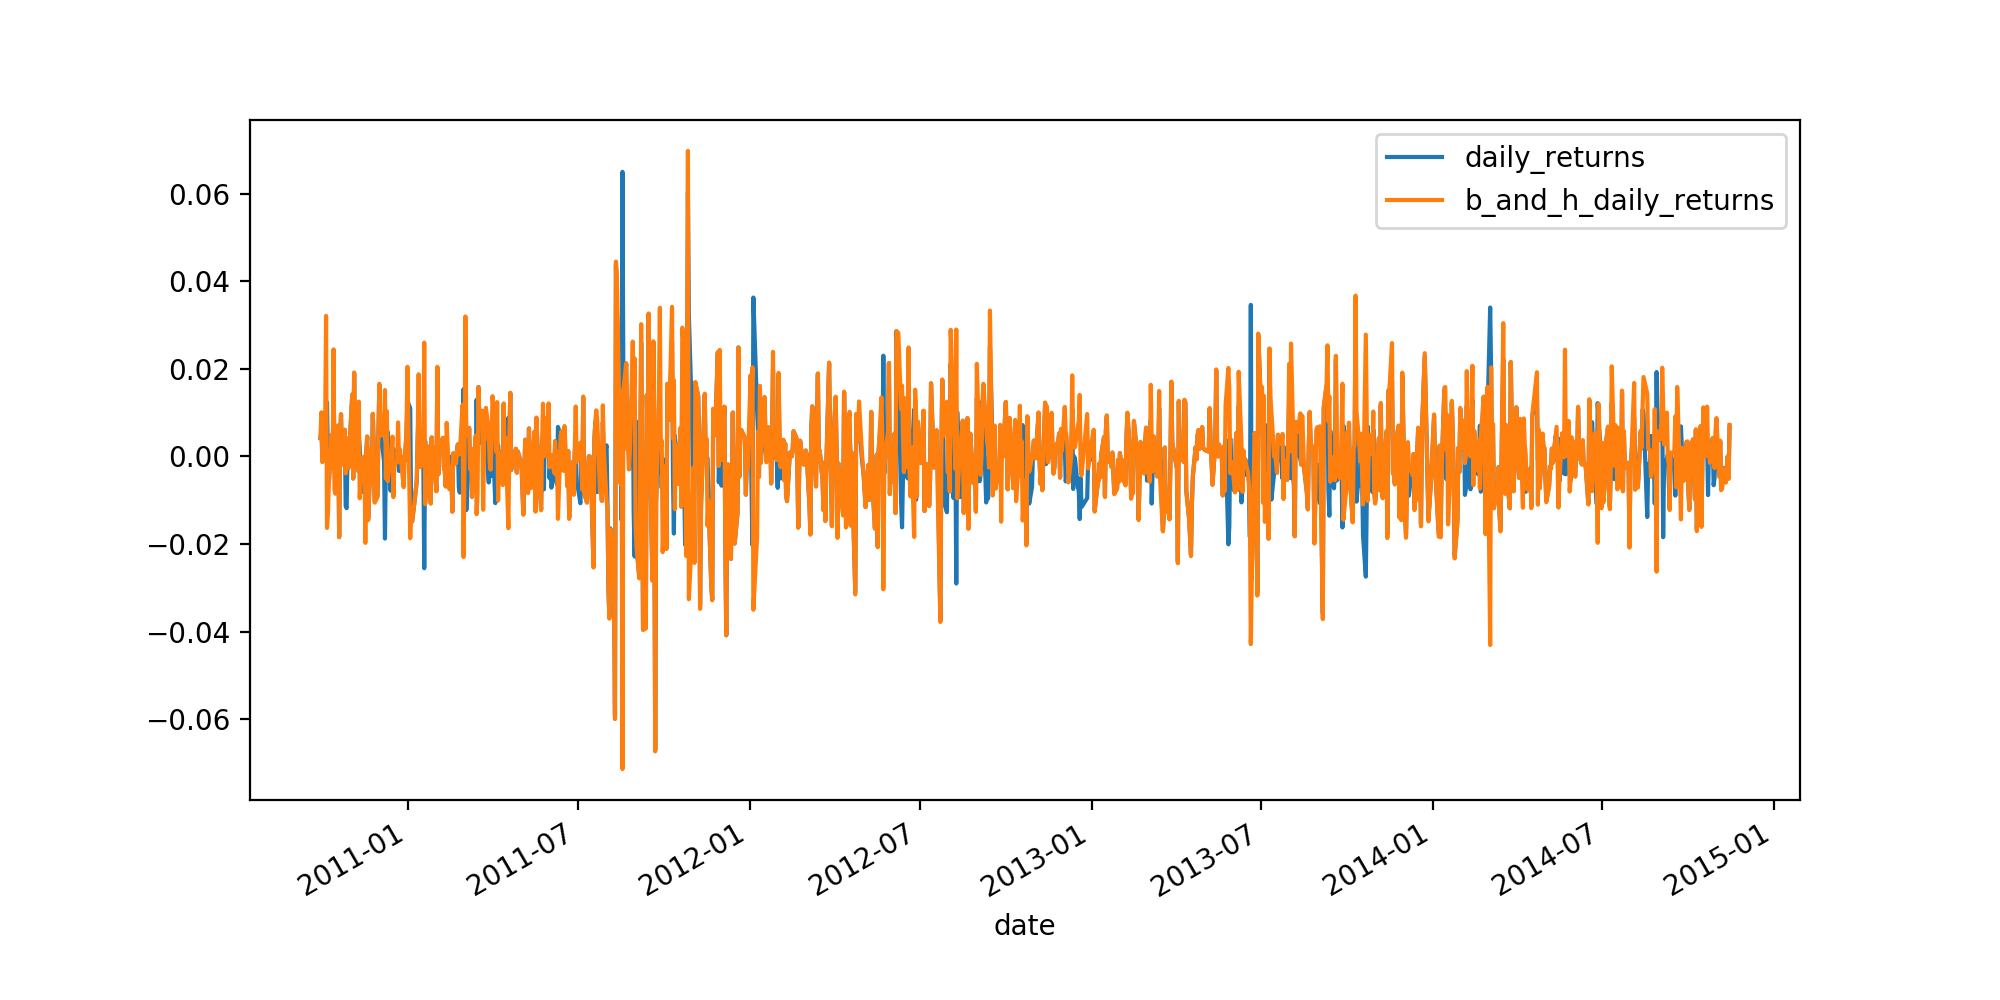

In [64]:
# etf_t.head(10)
t = etf_t.plot(y=['daily_returns','b_and_h_daily_returns'])

<IPython.core.display.Javascript object>


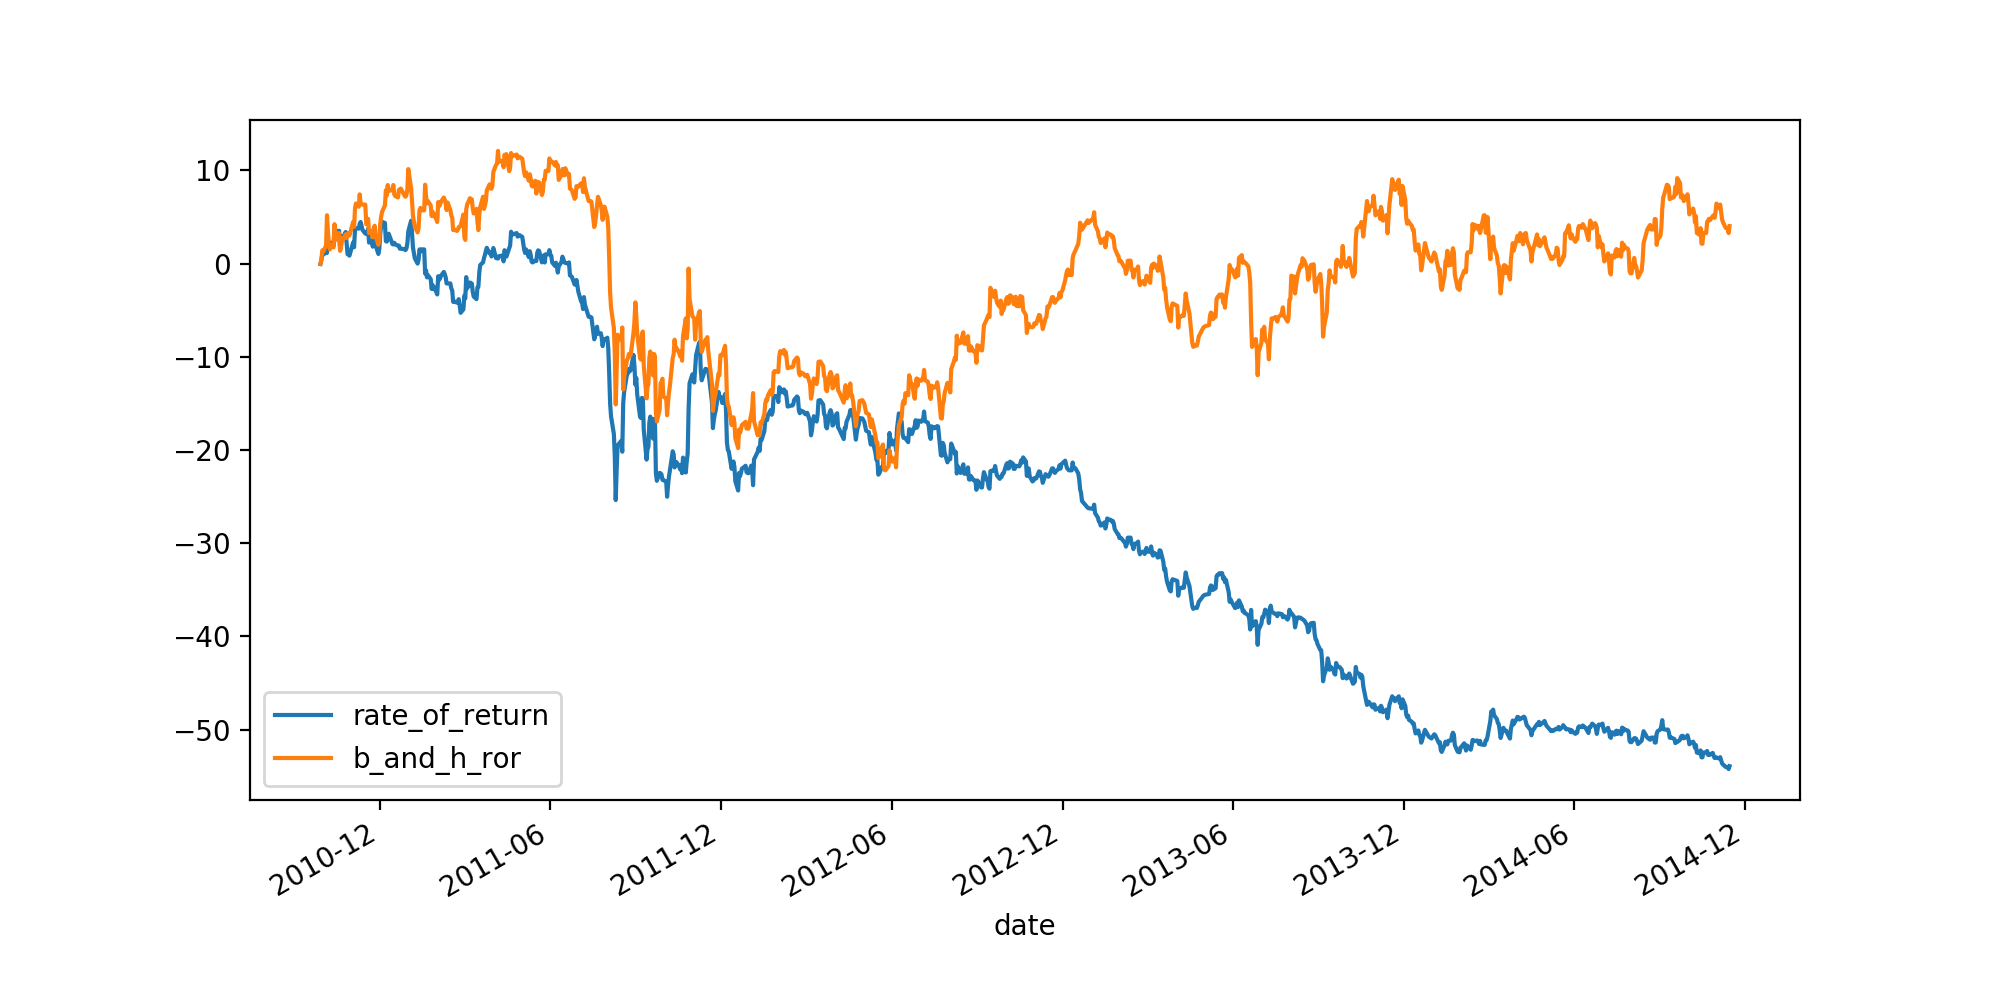

<IPython.core.display.Javascript object>


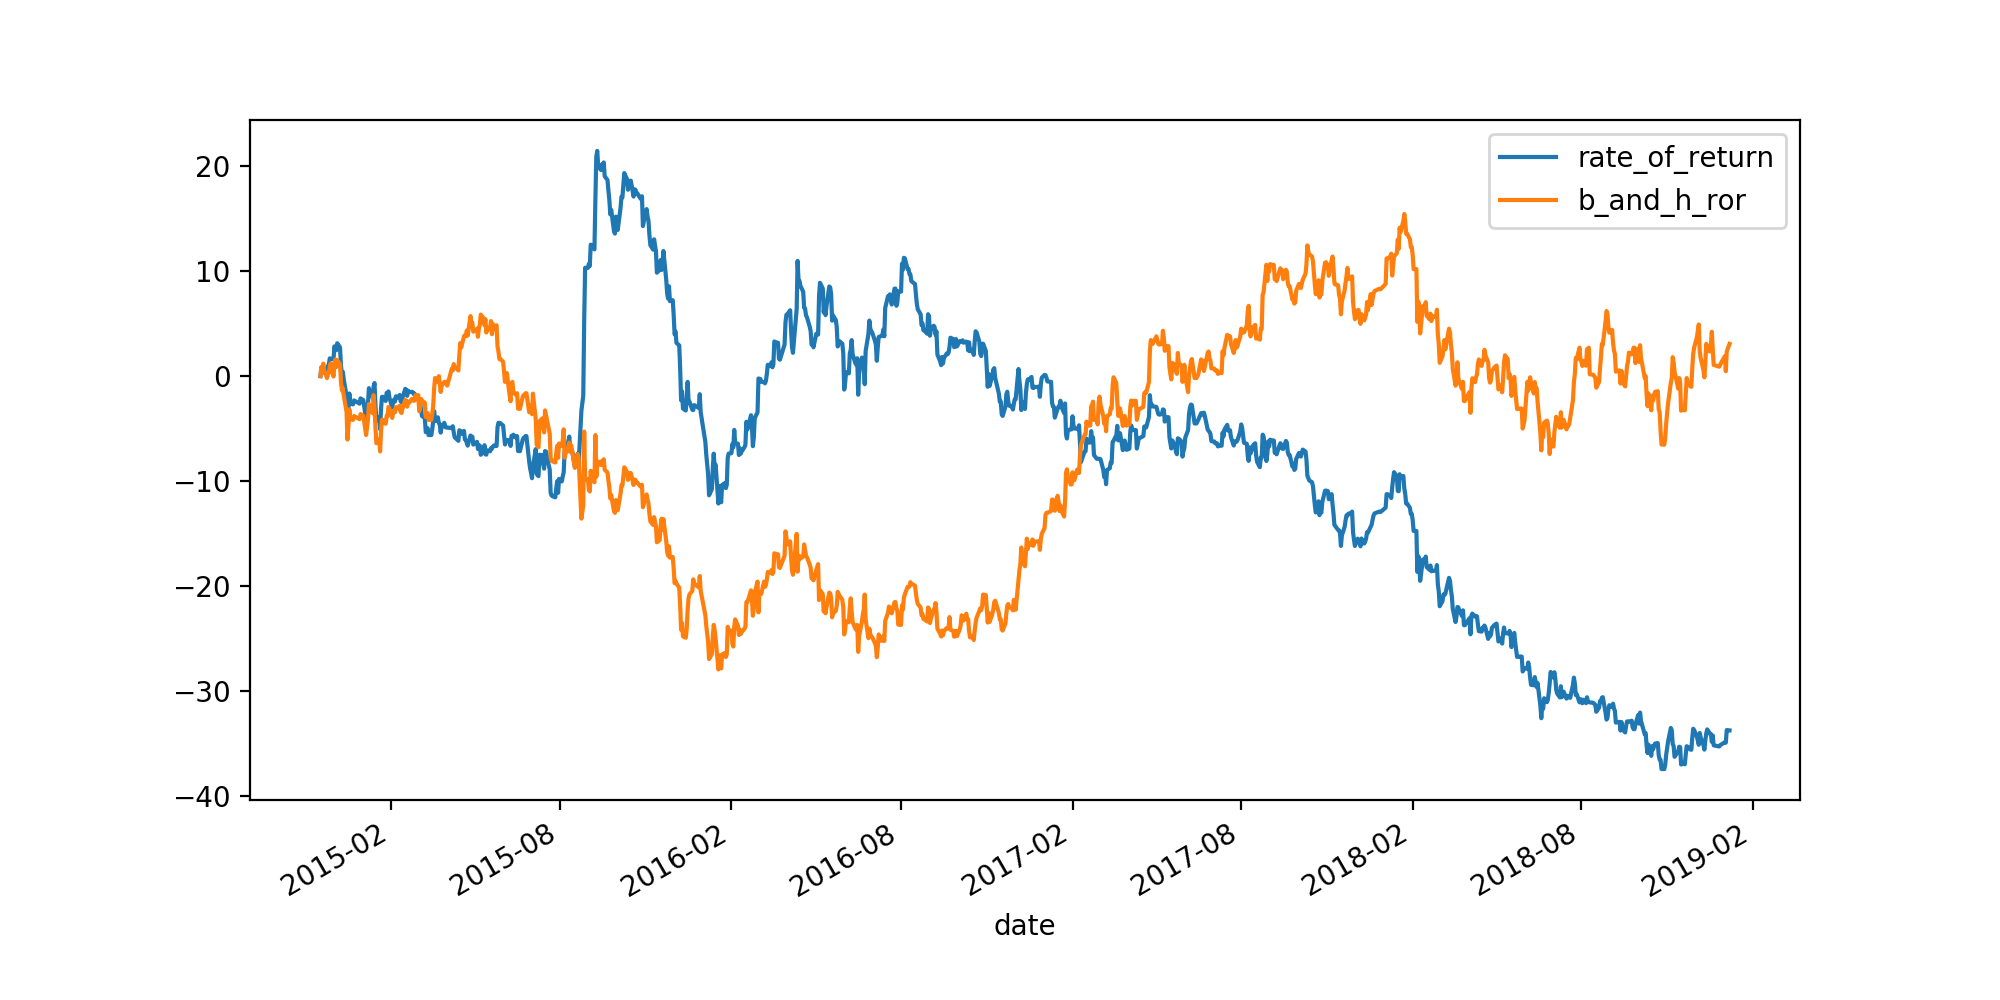

In [121]:
# just to check if graphs looks legit
ax3 = etf_t.plot(y=['rate_of_return', 'b_and_h_ror'])
ax4 = etf_v.plot(y=['rate_of_return', 'b_and_h_ror'])

In [131]:
# evaluate results...
"""
sharpe
maximum drowndown
reutrns
std dev returns
alpha
"""
def evaluate(df, returns_col, rate_of_returns_col):
    """
    Notes: I've lost a lot of code... That's so strage as I was saving in this notebook.... Cannot relay
    on jupyter notebooks... That's very disappointing. Push more to git.
    
    Excess daily returns assuming risk-free rate of 2% per annum and 252 trading days in a year
    
    Function outputs (or rather was outputing in previous verios)
        - Annualized Sharpe Ratio
        - Maximum Drowndown
        - Maximum Drowndown Duration
        - Expectation
        - Annualized Returns
        - No. of trades
    """
    # sharpe ratio
    excess_returns = df[returns_col] - 0.02/252
    mean_er = excess_returns.mean()
    std_dev_er = excess_returns.std()
    annualized_sharpe_ratio=(252**.5)*mean_er/std_dev_er
    # return annualized_sharpe_ratio
    print('annualized_sharpe_ratio: ', annualized_sharpe_ratio)

    # maximum draw down
    # TODO(slaw) - can it be done in vectorized form in pandas???
    """
    high watermark can be done (there is some sort of function for such a operation)
    drowndown is easy - just substraction and then max
    maximum drawdown duration should also be some sort of rolling metric... note: its longet drown down, not 
    how long maximum drowndown lasted
    """
    cum_ret = np.array(df[rate_of_returns_col])
    cum_ret_lenght = len(cum_ret)
    
    highwatermark = np.zeros(cum_ret_lenght)
    drawdown = np.zeros(cum_ret_lenght)
    drawdownduration = np.zeros(cum_ret_lenght)
    for idx in range(1,cum_ret_lenght):
        highwatermark[idx] = max(
            highwatermark[idx-1], cum_ret[idx]
        )
        drawdown[idx] = highwatermark[idx] - cum_ret[idx]
        
        if drawdown[idx] == 0:
            drawdownduration[idx]=0
        else:
            drawdownduration[idx]=drawdownduration[idx-1]+1
            
    maximum_drawdown = max(drawdown)
    print('maximum_drawdown: ', maximum_drawdown)
    maximum_drawdown_duration = max(drawdownduration)
    print('maximum_drawdown_duration:', maximum_drawdown_duration)
    
    # still drowndowns but with vectorized pandas or numpy now...
    # you can use .cummax()

    
    
print('For strategy:')
evaluate(etf_t, 'daily_returns', 'rate_of_return')
print('\n')
print('For benchmark:')
evaluate(etf_t, 'b_and_h_daily_returns', 'b_and_h_ror')



For strategy:
annualized_sharpe_ratio:  -1.1328817250435885
maximum_drawdown:  58.823099999999855
maximum_drawdown_duration: 965.0


For benchmark:
annualized_sharpe_ratio:  0.043053806662726256
maximum_drawdown:  34.253306231022115
maximum_drawdown_duration: 899.0


In [145]:
tdf = pd.DataFrame(
        {'a':[1,4,7,3,2,1,8,4,3,2,1,5,6,7,9,4], 'b':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
)
print(tdf)

s1  = tdf['a'].rolling(1).max()
# print(sss)

s2 = tdf['a'].cummax()

print(s2)

    a   b
0   1   1
1   4   2
2   7   3
3   3   4
4   2   5
5   1   6
6   8   7
7   4   8
8   3   9
9   2  10
10  1  11
11  5  12
12  6  13
13  7  14
14  9  15
15  4  16
0     1
1     4
2     7
3     7
4     7
5     7
6     8
7     8
8     8
9     8
10    8
11    8
12    8
13    8
14    9
15    9
Name: a, dtype: int64


In [1]:
"""
ehhhh.....

starcilem kod do ewaluacji itp.... no trudno.

mialem zrobione:
- max dd uzywajac tylko np (a nie petli)
- expectation (z mechanizmem trades itp)
- sharpe ratio
- annualized_returns
- no_trades
"""

import pickle

with open('s1_all_results.pkl', 'rb') as fh:
    s1_results = pickle.load(fh)
    

In [14]:
rs = [x for x in s1_results if x['annualized_returns']>0]
ordered_results = sorted(rs, key=lambda x: x['annualized_returns'], reverse=True)
print(ordered_results[1:10])

[{'sharpe': 0.13027929272846264, 'max_dd': 29.445, 'max_dd_duration': 842, 'annualized_returns': 3.808505263316775, 'no_trades': 52, 'expectancy': -1.0096153846153868}, {'sharpe': 0.12738908313333072, 'max_dd': 30.264200000000002, 'max_dd_duration': 839, 'annualized_returns': 3.755925293860485, 'no_trades': 42, 'expectancy': 19.51380952380954}, {'sharpe': 0.11252663130711202, 'max_dd': 31.966200000000008, 'max_dd_duration': 838, 'annualized_returns': 3.2990670949621492, 'no_trades': 42, 'expectancy': 0.947619047619014}, {'sharpe': 0.10532354808120115, 'max_dd': 30.264200000000002, 'max_dd_duration': 840, 'annualized_returns': 3.152986916750211, 'no_trades': 30, 'expectancy': 32.232333333333344}, {'sharpe': 0.10303390353003138, 'max_dd': 31.756600000000006, 'max_dd_duration': 861, 'annualized_returns': 3.0078678877150544, 'no_trades': 18, 'expectancy': 33.26944444444442}, {'sharpe': 0.09434917248335918, 'max_dd': 30.264200000000002, 'max_dd_duration': 889, 'annualized_returns': 2.872383

In [16]:
rs = [x for x in s1_results if x['expectancy']>0]
ordered_results = sorted(rs, key=lambda x: x['expectancy'], reverse=True)
print(ordered_results[1:10])

[{'sharpe': 0.047224908720728404, 'max_dd': 34.124, 'max_dd_duration': 899, 'annualized_returns': 1.4191040005828492, 'no_trades': 6, 'expectancy': 125.465}, {'sharpe': 0.047224908720728404, 'max_dd': 34.124, 'max_dd_duration': 899, 'annualized_returns': 1.4191040005828492, 'no_trades': 6, 'expectancy': 125.465}, {'sharpe': 0.047224908720728404, 'max_dd': 34.124, 'max_dd_duration': 899, 'annualized_returns': 1.4191040005828492, 'no_trades': 6, 'expectancy': 125.465}, {'sharpe': 0.061389441216709965, 'max_dd': 34.124, 'max_dd_duration': 899, 'annualized_returns': 1.8300723963073917, 'no_trades': 7, 'expectancy': 115.04857142857142}, {'sharpe': 0.0260959594174356, 'max_dd': 34.124, 'max_dd_duration': 899, 'annualized_returns': 0.8001436226230618, 'no_trades': 3, 'expectancy': 112.84999999999997}, {'sharpe': 0.07011028919519145, 'max_dd': 31.756600000000006, 'max_dd_duration': 899, 'annualized_returns': 2.1168792115656254, 'no_trades': 9, 'expectancy': 106.27777777777783}, {'sharpe': 0.05